In [1]:
%matplotlib inline
import qiime2 as q2

import seaborn as sns, pandas as pd, numpy as np

from scipy.stats import zscore
from matplotlib.pylab import plt

from biom import Table

load_mf = lambda x: q2.Metadata.load(x).to_dataframe()

In [2]:
cd trimmed-150nts/

/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/HastyWater/trimmed-150nts


In [3]:
a_bt = q2.Artifact.load('feature-table.even.18813.normalized.qza')
bt = a_bt.view(Table)
mf = load_mf('mapping-file.alpha.tsv')

# for this notebook we only operate on the digesters, and not on the *control* samples
mf = mf[mf.Description.isin(['Digester%d' % i for i in range(1, 5)])].copy()
mf['day'] = pd.to_numeric(mf['day'])

In [4]:
mf.Description.value_counts()

Digester1    29
Digester2    29
Digester4    29
Digester3    29
Name: Description, dtype: int64

In [5]:
bt_df = a_bt.view(pd.DataFrame)

In [6]:
at_least_fifty = bt_df.columns[bt_df.sum(axis=0) > 50]

In [7]:
no_zero_variance = bt_df.columns[bt_df.var(axis=0) > 5]

# All digesters at once

In [8]:
mkdir -p heatmaps-normalized

In [9]:
bt_df[at_least_fifty].shape

(118, 3150)

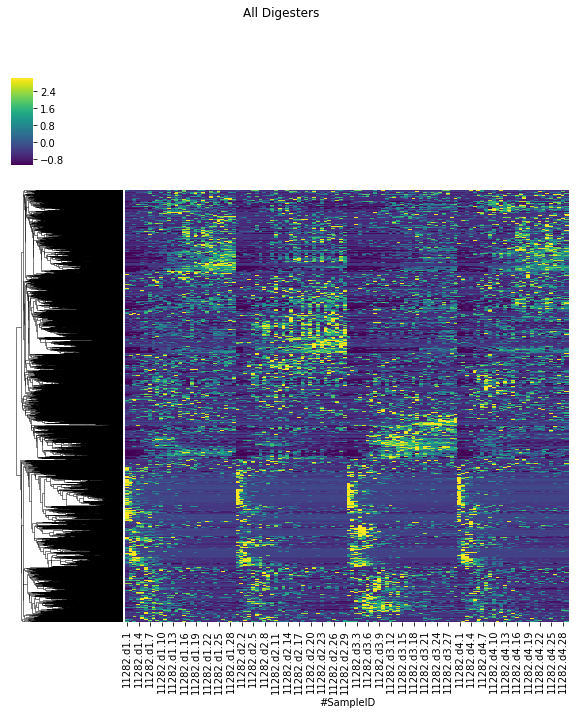

In [10]:
transformed = bt_df[at_least_fifty].copy()

mf.sort_values(by=['Description', 'day'], axis=0, inplace=True)
transformed = transformed.loc[mf.index]

transformed = transformed.apply(zscore, axis=0)
transformed.dropna(axis=1, inplace=True)

g = sns.clustermap(transformed.T, col_cluster=False, cmap='viridis', yticklabels=False, robust=True)
g.fig.suptitle('All Digesters')
g.savefig('heatmaps-normalized/all.pdf')

# One digester at a time

Note that we need to do the variance filtering on a per digester basis, otherwise we might find a situation where we end up trying to cluster rows that are full of zeros, and the z-score ends with nans everywhere.

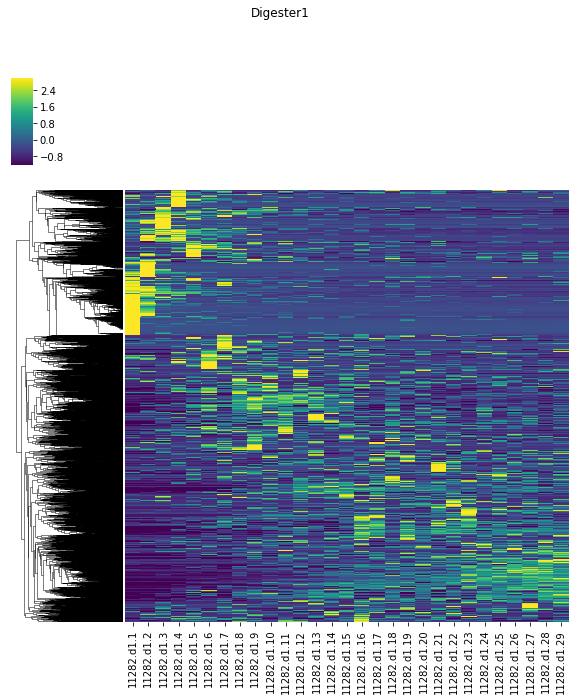

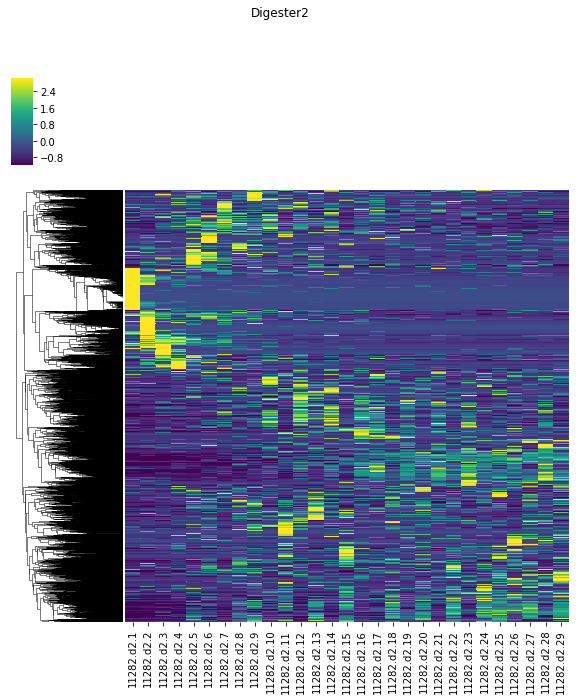

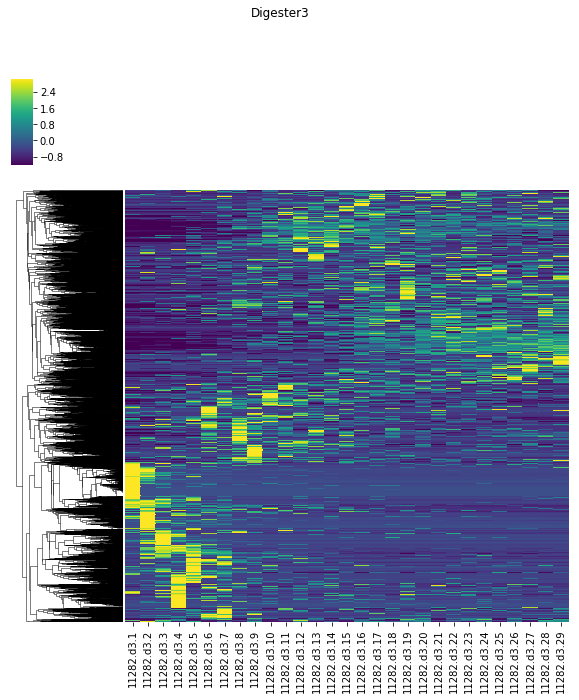

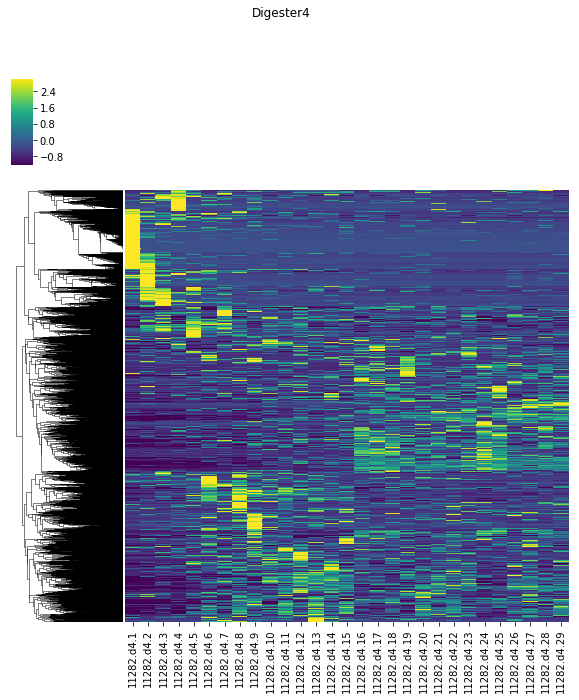

In [11]:
transformed = bt_df.copy()
transformed['Description'] = mf['Description'].copy()
transformed['day'] = mf['day'].copy()

for label, group in transformed.groupby('Description'):
    group = group.copy()
    
    group.sort_values('day', inplace=True)
    group.drop(['day', 'Description'], inplace=True, axis=1)
    
    group = group[group.columns[group.var(axis=0) > 1]]
    group = group.apply(zscore, axis=0)

    g = sns.clustermap(group.T, col_cluster=False, cmap='viridis', yticklabels=False, robust=True)
    g.fig.suptitle(label)
    g.savefig('heatmaps-normalized/%s.pdf' % label)